<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep18-eda-modeling-submission?scriptVersionId=135058088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (06/26/2023)
    * EDA 
    * Baseline modeling 1.0
    
    
2. Version 2 (06/27/2023)
    * Baseline modeling 1.0 updated.


3. Version 3 (06/27/2023)
    * Fixing bug in barplot.
    
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 8.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from flaml import AutoML

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [3]:
train = pd.read_csv('../input/playground-series-s3e18/train.csv')
test = pd.read_csv('../input/playground-series-s3e18/test.csv')
submission = pd.read_csv('../input/playground-series-s3e18/sample_submission.csv')

print('The dimension of the train synthetic dataset is:', train.shape)
print('The dimension of the test synthetic dataset is:', test.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train synthetic dataset is: (14838, 38)
The dimension of the test synthetic dataset is: (9893, 32)
The dimension of the submission dataset is: (9893, 3)


In [4]:
train.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,222.068080,1.181818,1.727273,2.363636,-0.24,212.163,8.170000,11.922504,0.171585,4,0.000000,91.536492,0.000000,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,260.029719,1.346154,2.076923,2.769231,-0.09,247.031,3.201491,10.932338,-4.830450,10,24.415866,7.822697,0.000000,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,382.131027,1.085714,1.742857,2.400000,-0.78,354.106,15.033890,11.238048,-5.066255,9,0.000000,15.645394,0.000000,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,530.070277,1.162791,1.573770,2.270270,-1.30,506.124,6.724301,11.171170,-5.276575,19,42.727765,21.335138,0.000000,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,118.062994,1.444444,2.111111,2.555556,-1.10,108.056,3.931272,9.855741,-1.676296,4,6.041841,11.938611,6.923737,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2,1,0,1,1,1,0


In [5]:
train.describe()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
count,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,7418.500000,515.153604,9.135189,5.854307,6.738497,4.432570,5.253221,3.418749,1.773472,29.202823,10.435316,292.623087,1.236774,1.812070,2.255470,-1.207776,274.950211,5.874372,10.556443,-2.119772,8.584108,11.021644,17.790011,8.962440,11.318811,6.704487,15.666766,31.066423,13.636941,49.309959,0.458215,0.459226,0.667745,0.798962,0.313789,0.279081,0.144831,0.151570
std,4283.505982,542.456370,6.819989,4.647064,5.866444,3.760516,4.925065,3.436208,1.865898,31.728679,13.651843,225.384140,5.491284,5.495565,5.501200,0.935314,212.678755,45.730226,1.559331,2.066415,7.643769,13.958962,34.561655,19.756727,20.169745,10.865415,18.080208,33.896638,14.598554,29.174824,0.667948,0.668111,0.471038,0.400790,0.464047,0.448562,0.351942,0.358616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007276,-666.000000,-666.000000,-666.000000,-7.730000,0.000000,-104.040000,0.000000,-6.327514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.430556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3709.250000,149.103601,4.680739,2.844556,2.932842,1.949719,2.034468,1.160763,0.503897,5.969305,0.000000,148.037173,1.045455,1.690909,2.100000,-1.660000,136.109000,1.784008,9.926190,-4.659604,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.969305,6.420822,4.794537,30.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,7418.500000,290.987941,6.485270,4.052701,4.392859,2.970427,3.242775,1.948613,1.073261,17.353601,6.420822,206.042653,1.250000,1.865152,2.358491,-1.100000,194.276500,3.261011,10.421334,-1.265370,6.000000,6.041841,5.969305,0.000000,0.000000,0.000000,11.752550,20.075376,9.589074,41.666667,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,11127.750000,652.652585,11.170477,7.486791,8.527859,5.788793,6.609350,4.502070,2.534281,44.876559,12.841643,343.090331,1.500000,2.062153,2.500000,-0.570000,326.002000,5.848400,11.539743,-0.787037,10.000000,18.311899,15.645394,12.132734,13.847474,6.923737,17.721856,42.727765,14.912664,56.090650,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,14837.000000,4069.959780,69.551167,50.174588,53.431954,32.195368,34.579313,22.880836,16.072810,363.705954,99.936429,2237.318490,3.000000,3.200000,3.400000,0.820000,2035.133000,1512.242231,15.630251,6.000000,42.000000,97.663462,482.434223,375.425148,211.501279,100.348416,80.742293,492.729739,115.406157,384.450519,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing the variables of interest.

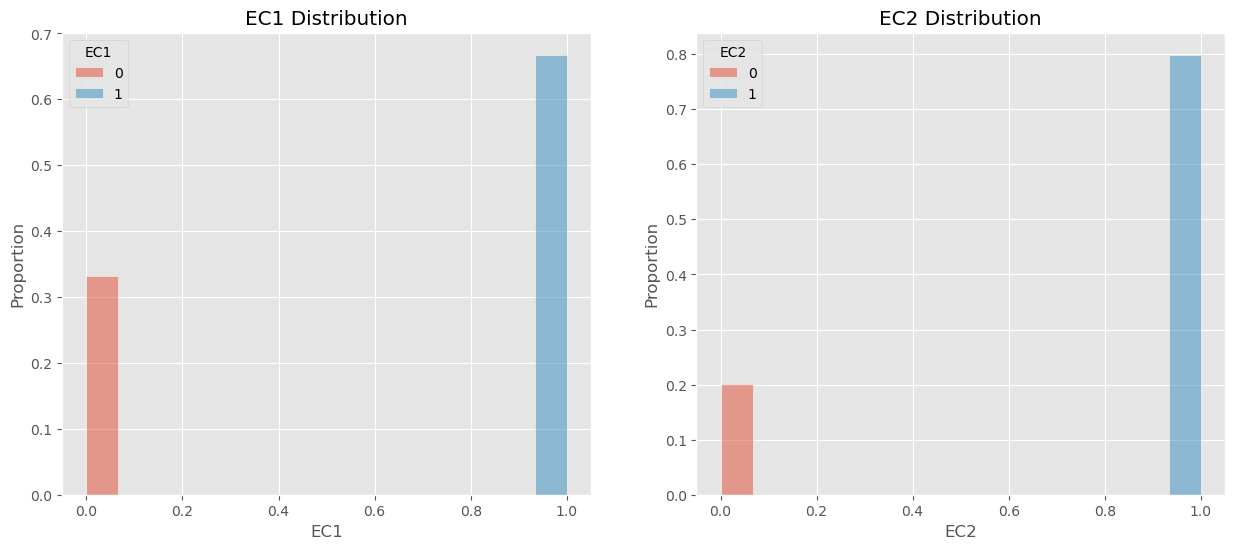

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.histplot(ax = axes[0], data = train, x = 'EC1', fill = True, hue = 'EC1', stat = 'proportion').set_title('EC1 Distribution');
sns.histplot(ax = axes[1], data = train, x = 'EC2', fill = True, hue = 'EC2', stat = 'proportion').set_title('EC2 Distribution');

First, we explore the relationship between the input features and `EC1`.

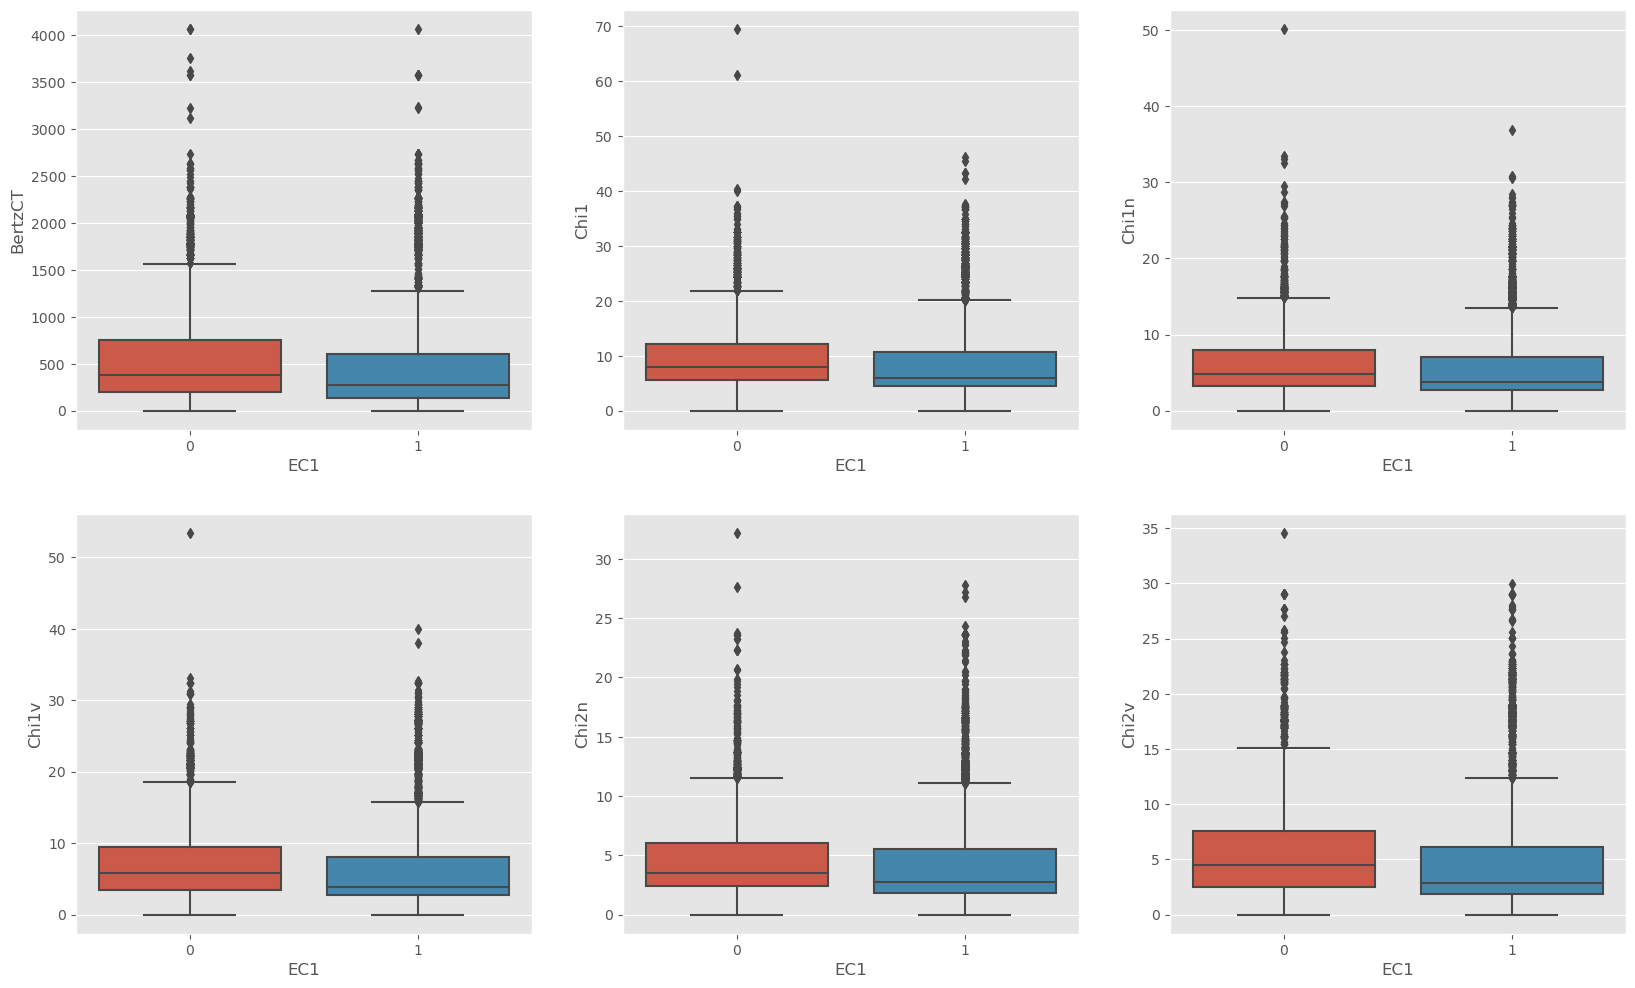

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC1', y = 'BertzCT')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC1', y = 'Chi1')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC1', y = 'Chi1n')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC1', y = 'Chi1v')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC1', y = 'Chi2n')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC1', y = 'Chi2v');

From the above boxplots, there is not an obvious pattern to exploit. 

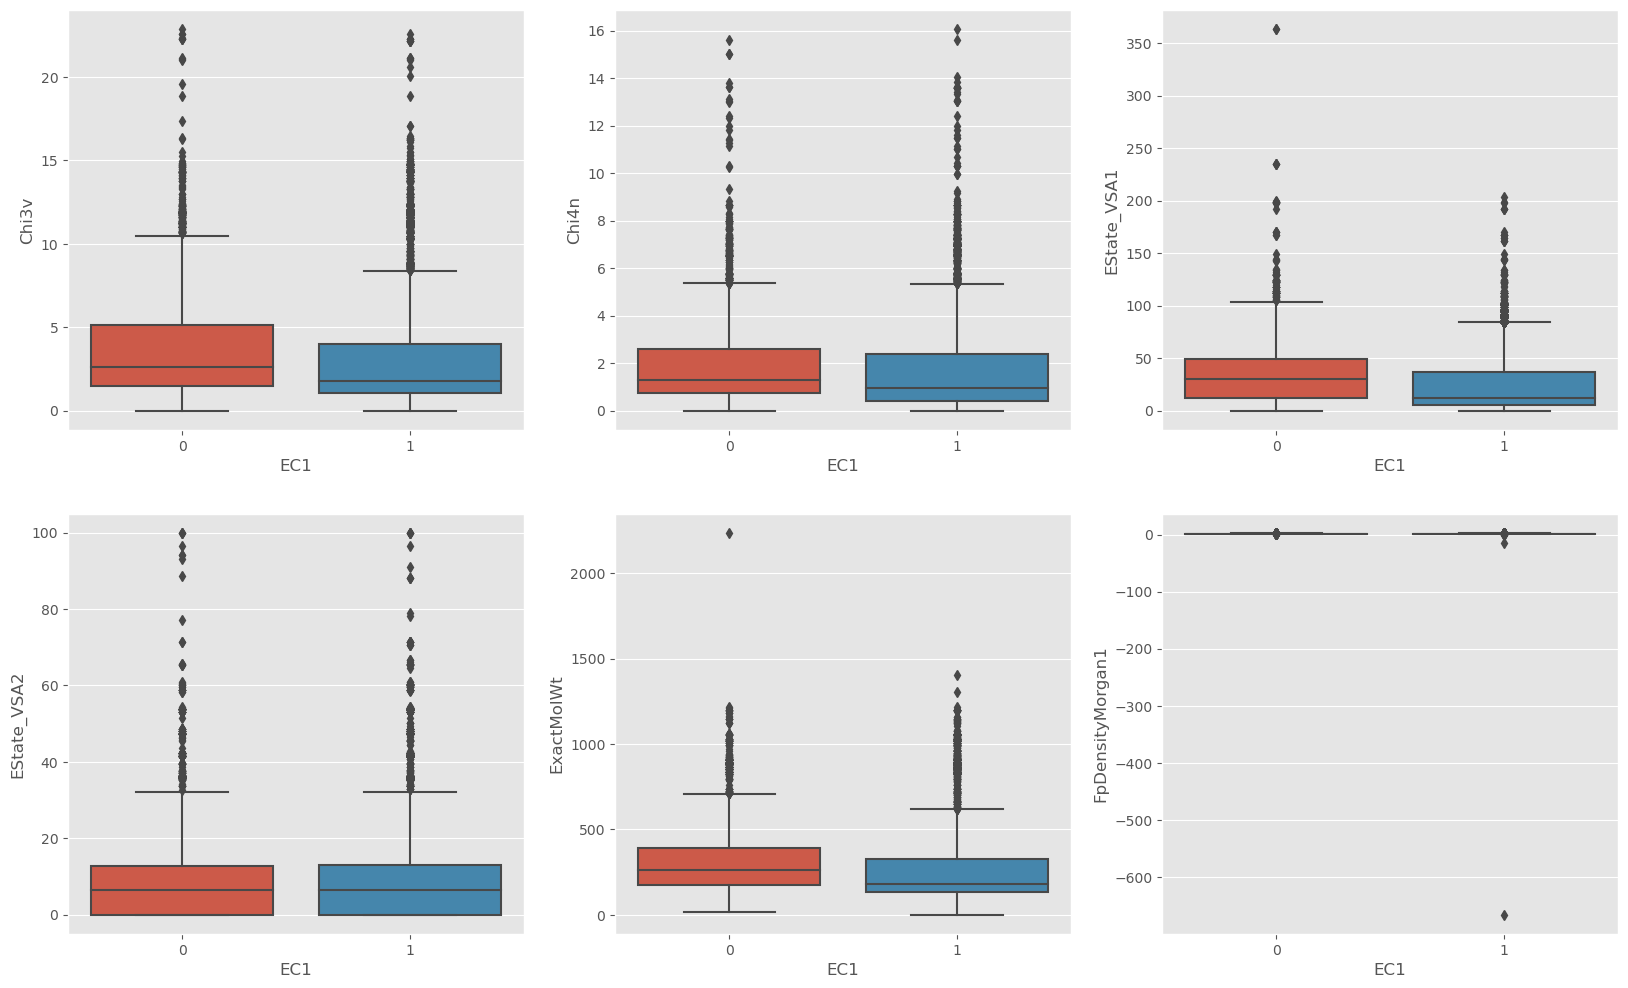

In [8]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC1', y = 'Chi3v')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC1', y = 'Chi4n')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC1', y = 'EState_VSA1')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC1', y = 'EState_VSA2')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC1', y = 'ExactMolWt')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC1', y = 'FpDensityMorgan1');

In the `FpDensityMorgan1` boxplot, there is a data point that is very different.

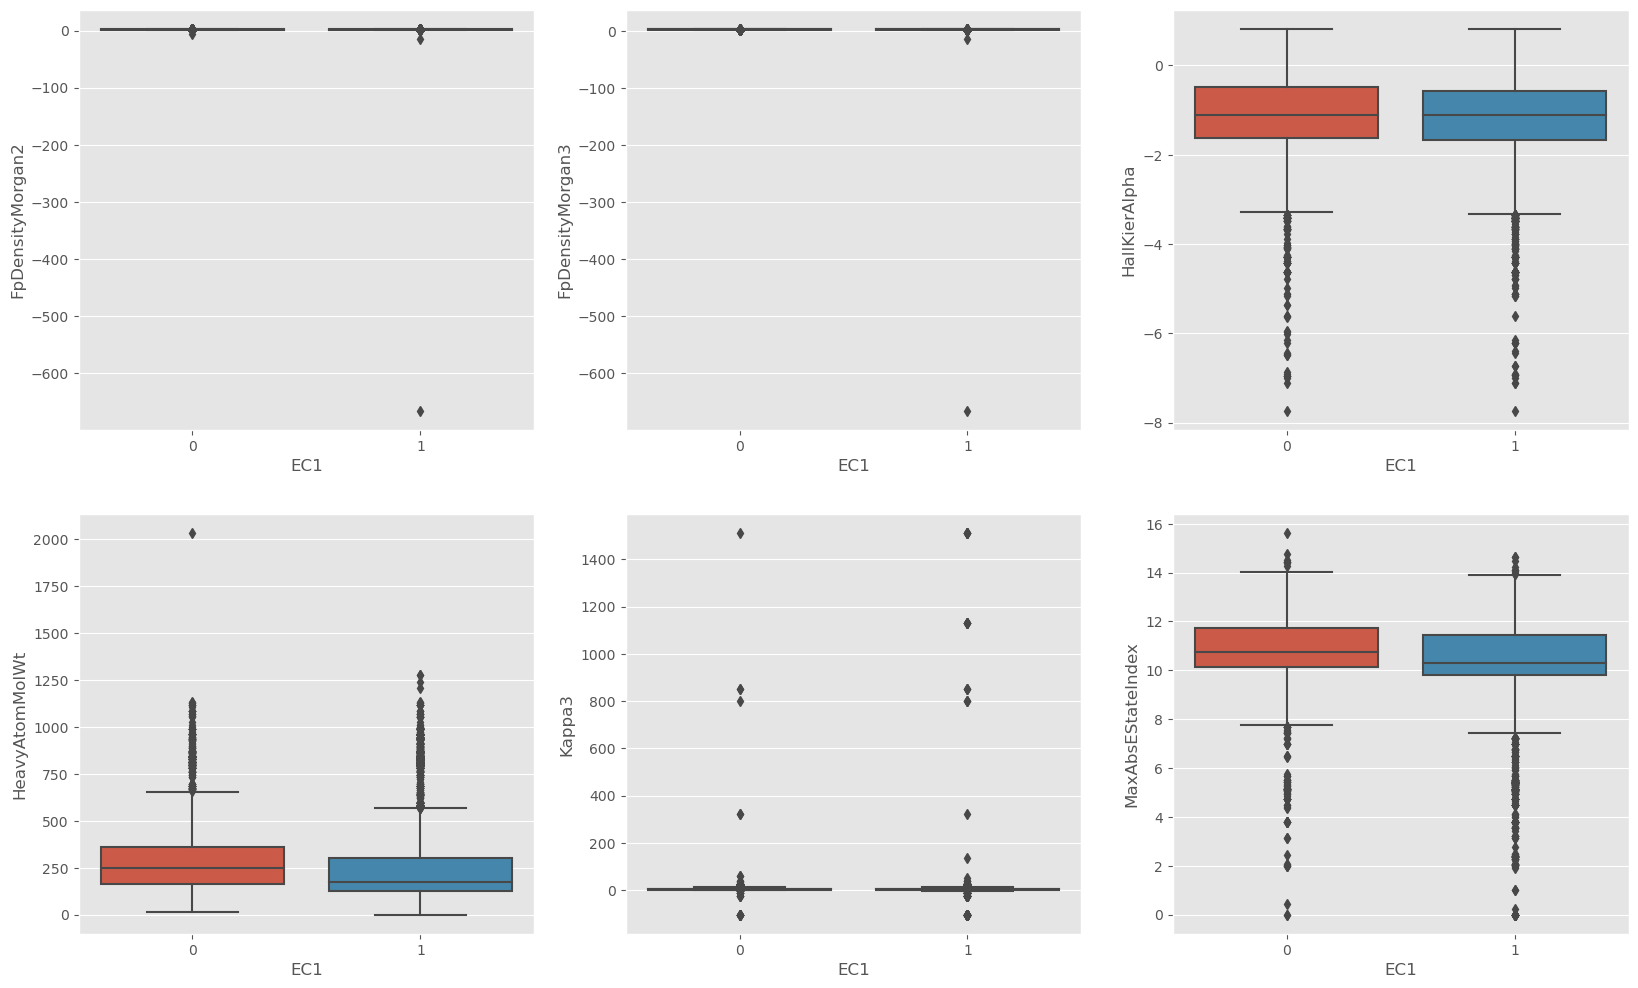

In [9]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC1', y = 'FpDensityMorgan2')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC1', y = 'FpDensityMorgan3')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC1', y = 'HallKierAlpha')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC1', y = 'HeavyAtomMolWt')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC1', y = 'Kappa3')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC1', y = 'MaxAbsEStateIndex');

In the `FpDensityMorgan2` and `FpDensityMorgan3` boxplos, there are data points that are very different.

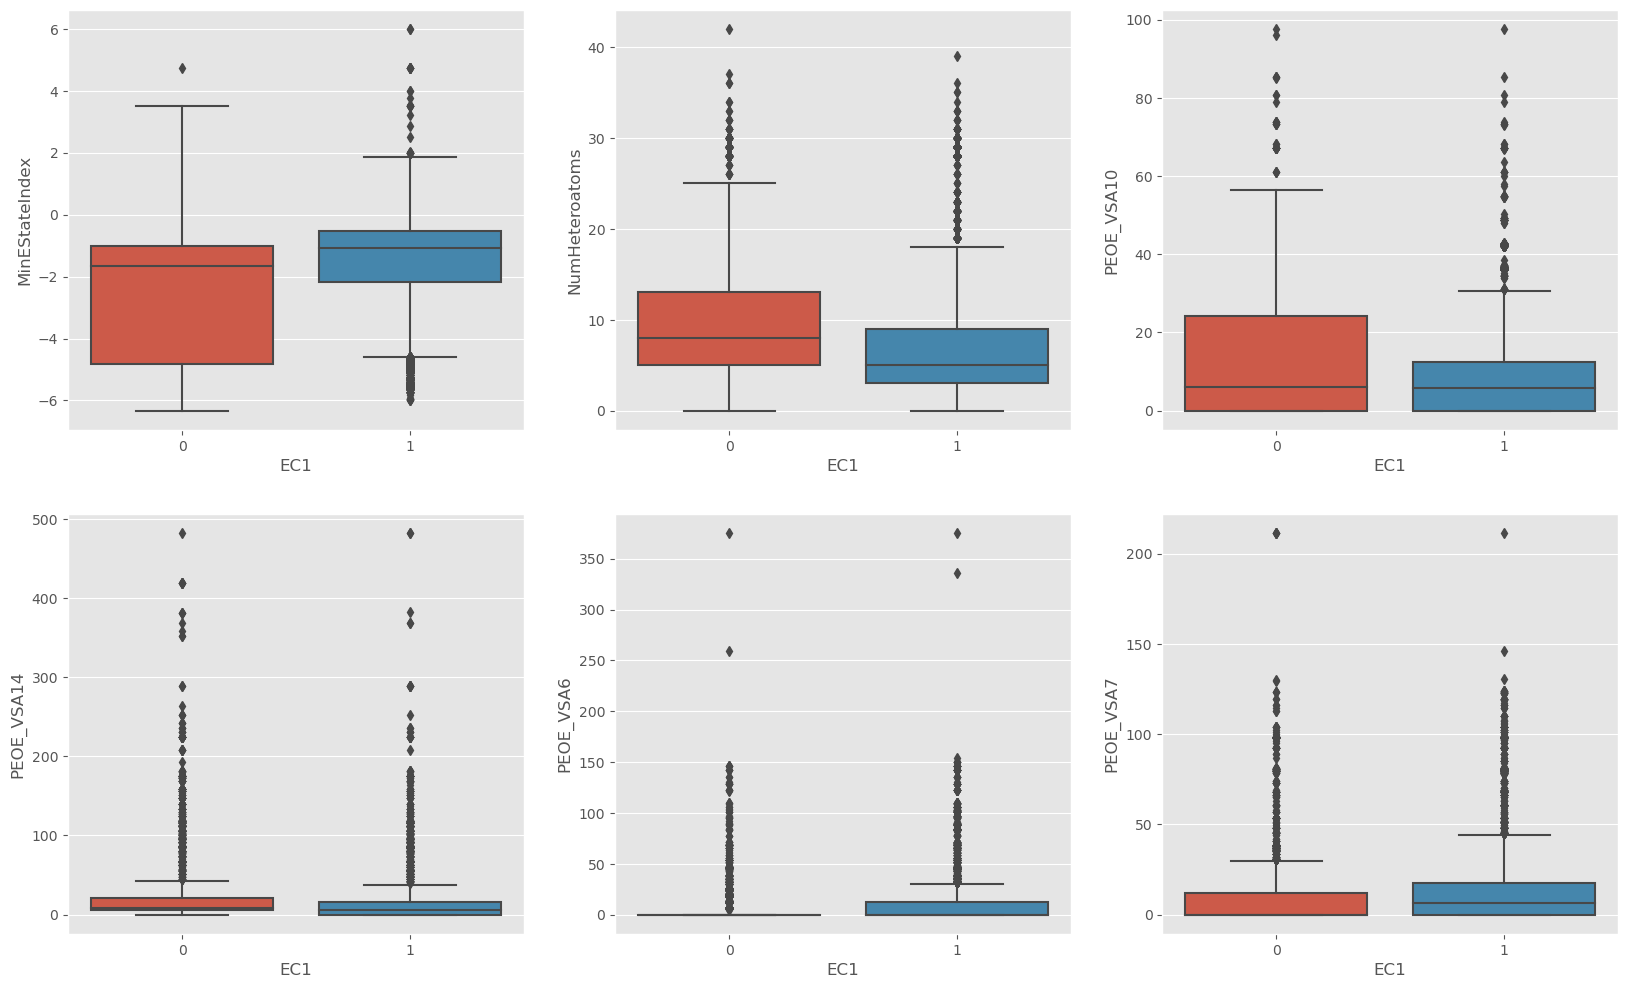

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC1', y = 'MinEStateIndex')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC1', y = 'NumHeteroatoms')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC1', y = 'PEOE_VSA10')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC1', y = 'PEOE_VSA14')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC1', y = 'PEOE_VSA6')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC1', y = 'PEOE_VSA7');

From the above boxplots, there is not an obvious pattern to exploit. 

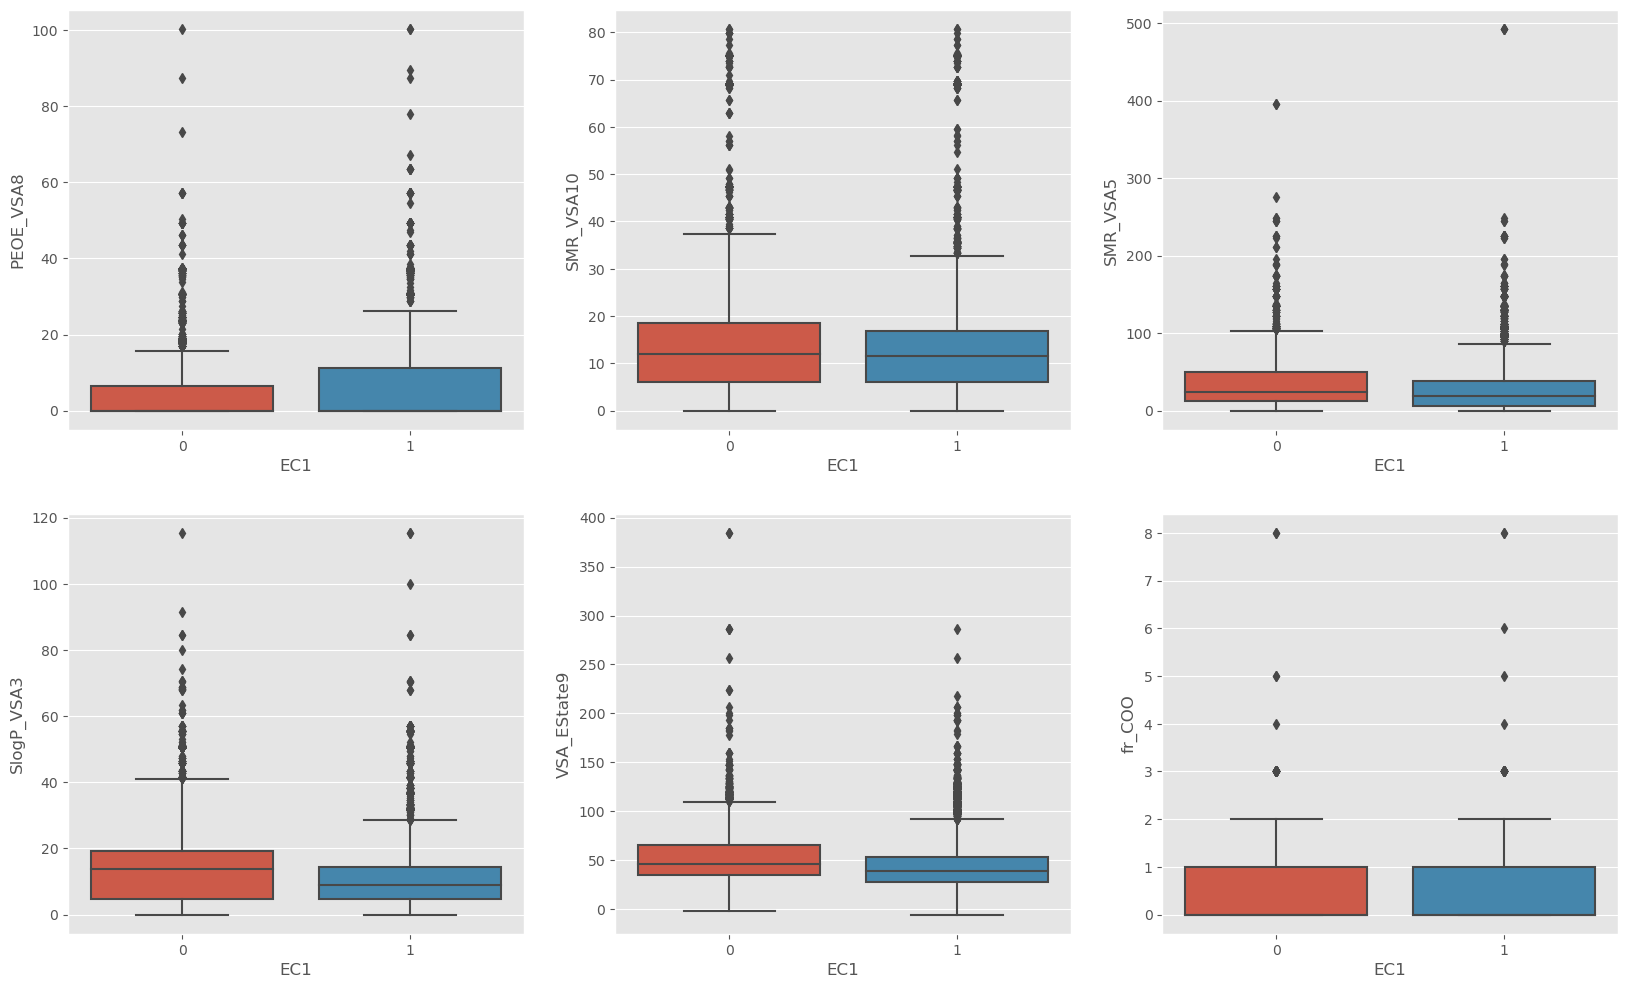

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC1', y = 'PEOE_VSA8')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC1', y = 'SMR_VSA10')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC1', y = 'SMR_VSA5')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC1', y = 'SlogP_VSA3')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC1', y = 'VSA_EState9')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC1', y = 'fr_COO');

From the above boxplots, there is not an obvious pattern to exploit. Next, we proceed to explore the correlations among the input features.

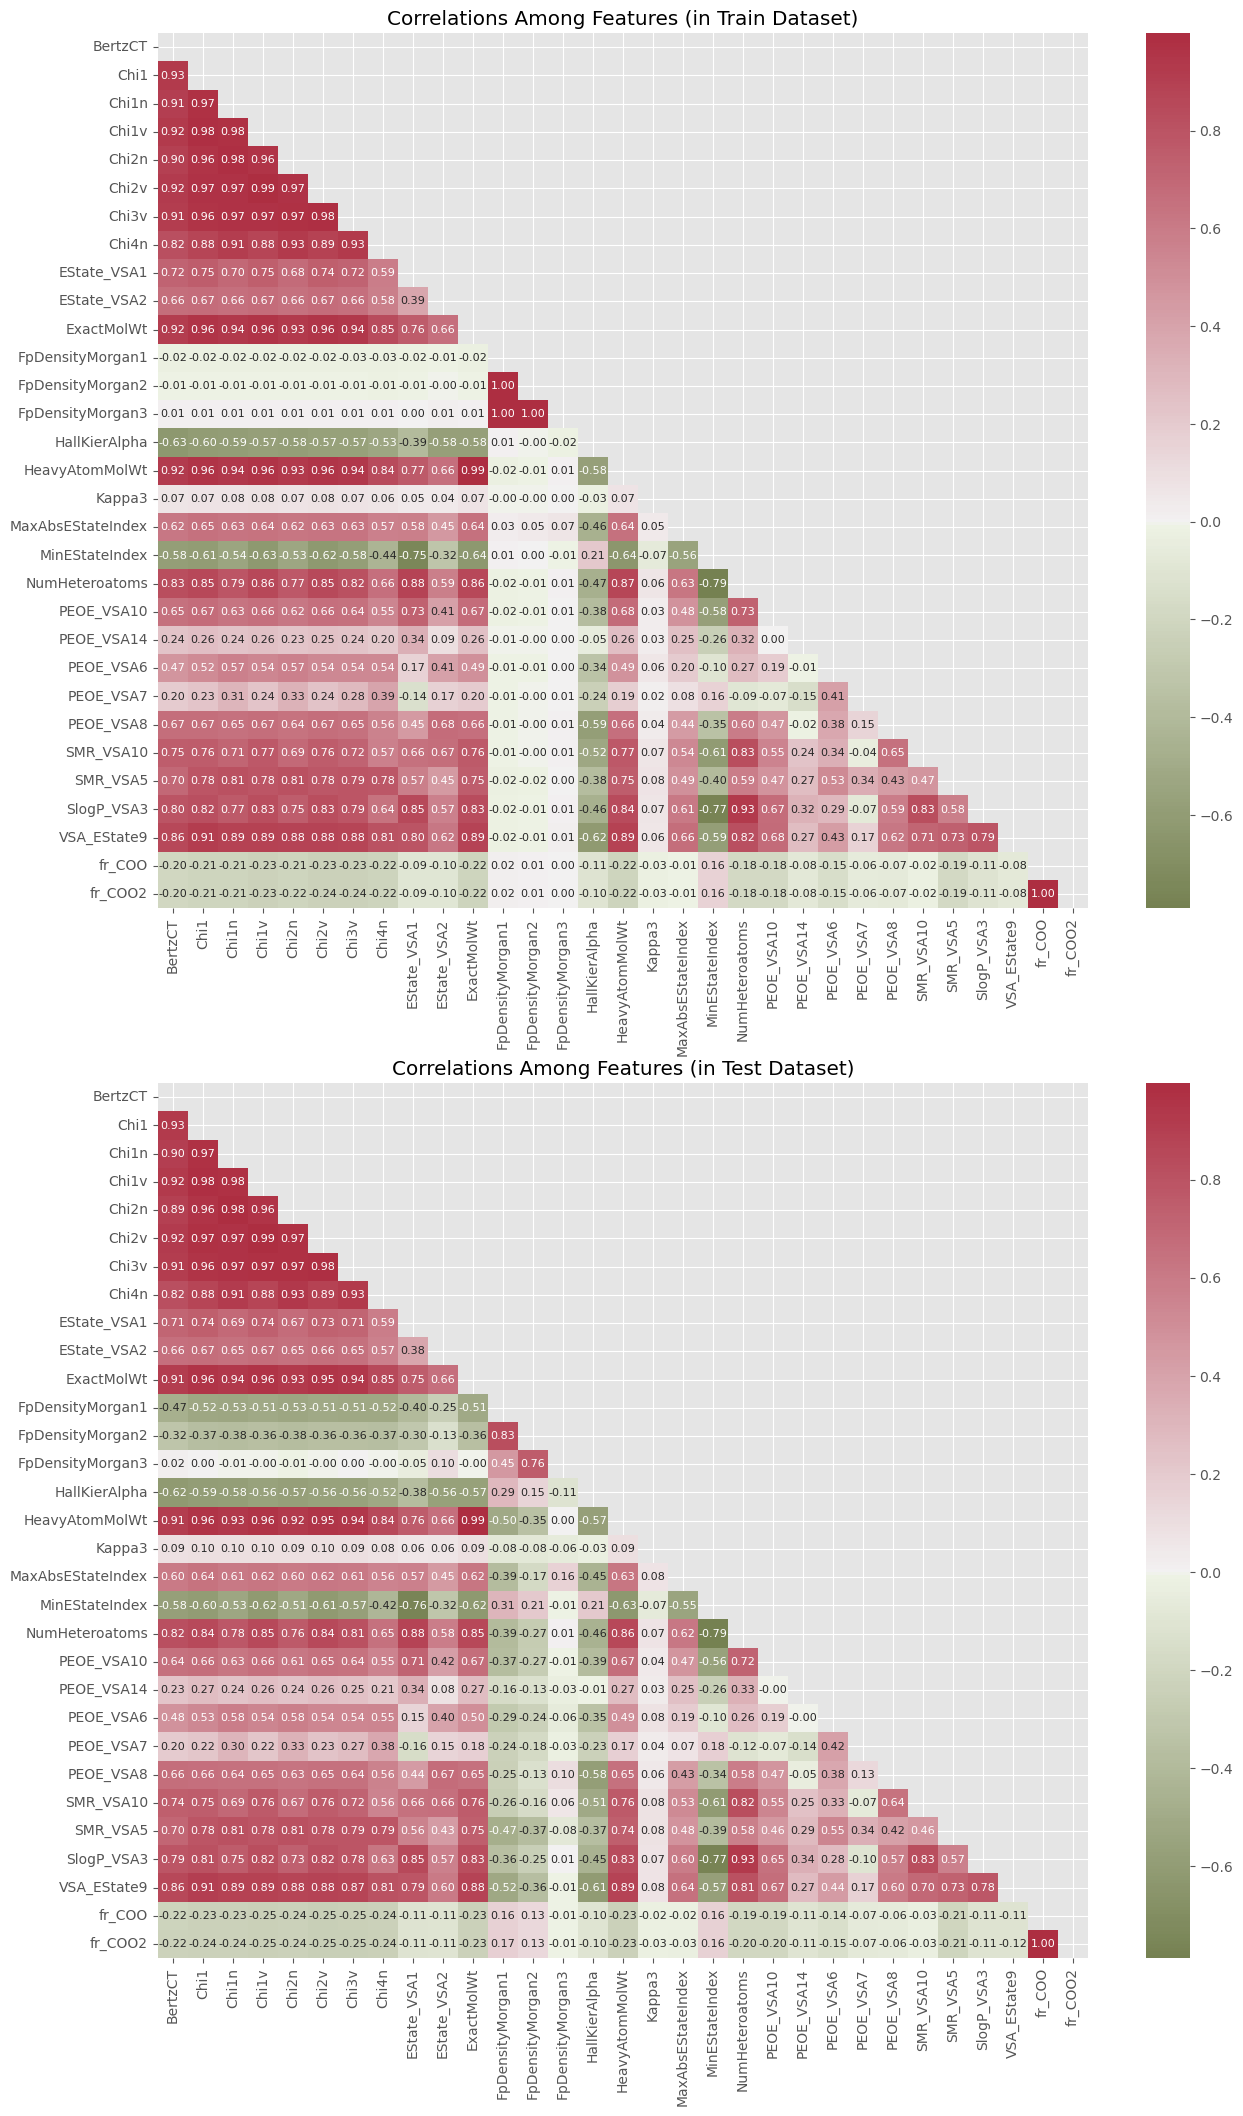

In [12]:
corr_mat_train = train.drop(columns = ['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

train_mask = np.triu(np.ones_like(corr_mat_train, dtype = bool))
test_mask = np.triu(np.ones_like(corr_mat_test, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

fig, axes = plt.subplots(2, 1, figsize = (15, 25))
sns.heatmap(corr_mat_train, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 8}, ax = axes[0], mask = train_mask).set_title('Correlations Among Features (in Train Dataset)')
sns.heatmap(corr_mat_test, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 8}, ax = axes[1], mask = test_mask).set_title('Correlations Among Features (in Test Dataset)');

From the above heatmaps, here are the takeaways:

- `fr_COO` and `fr_COO2` are perfectly correlated.
- `ExactMolWt` and `HeavyAtomMolWt` have a 0.99 correlation.
- Features that start with `Chi` are highly correlated.
- `HeavyAtomMolWt` is highly correlated with features that start with `Chi`.

Next, we explore the relationship between the input features and `EC2`.

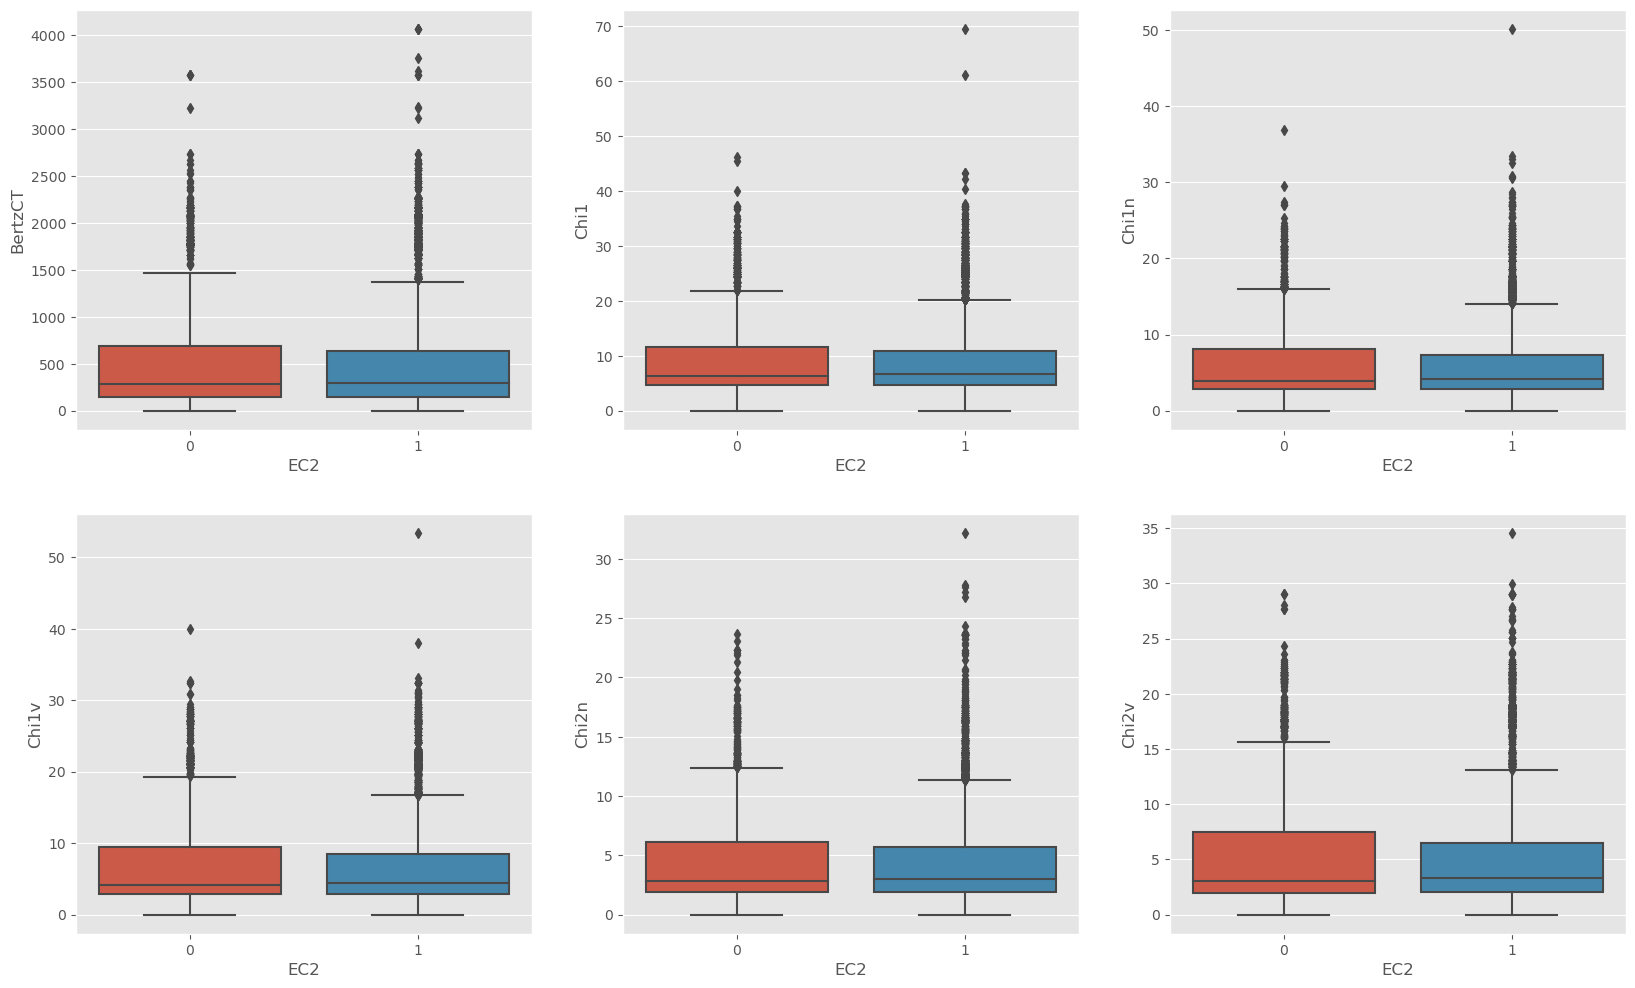

In [13]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC2', y = 'BertzCT')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC2', y = 'Chi1')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC2', y = 'Chi1n')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC2', y = 'Chi1v')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC2', y = 'Chi2n')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC2', y = 'Chi2v');

From the above boxplots, there is not an obvious pattern to exploit. 

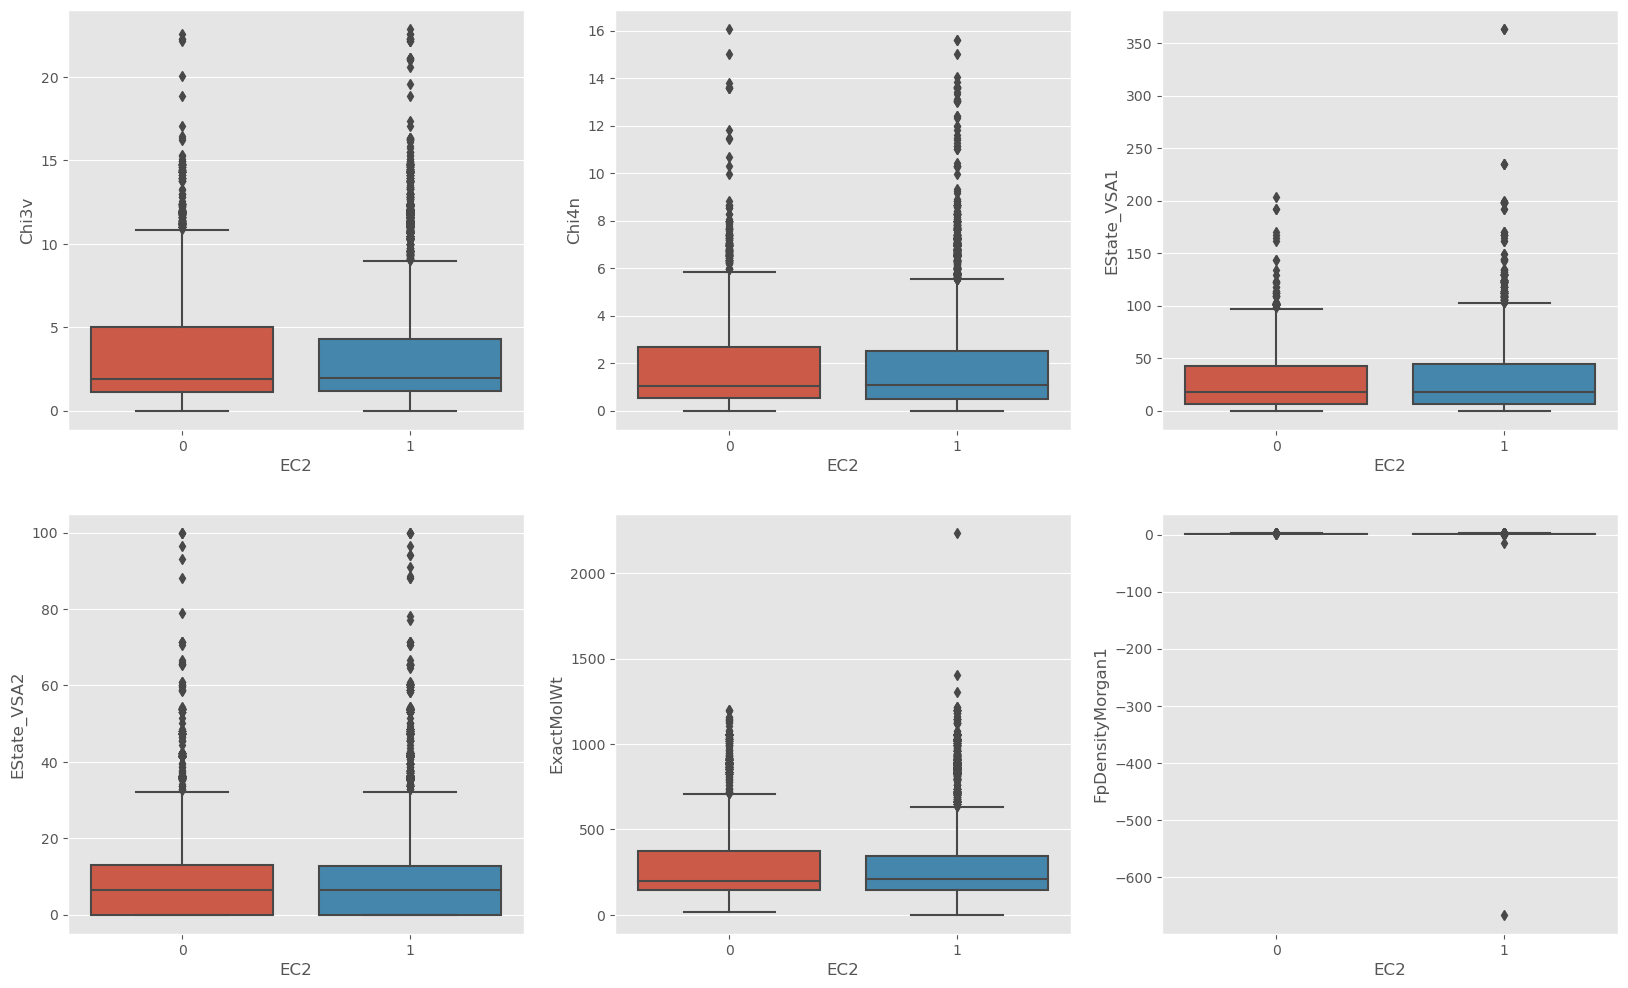

In [14]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC2', y = 'Chi3v')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC2', y = 'Chi4n')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC2', y = 'EState_VSA1')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC2', y = 'EState_VSA2')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC2', y = 'ExactMolWt')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC2', y = 'FpDensityMorgan1');

In the `FpDensityMorgan1` boxplot, there is a data point that is very different.

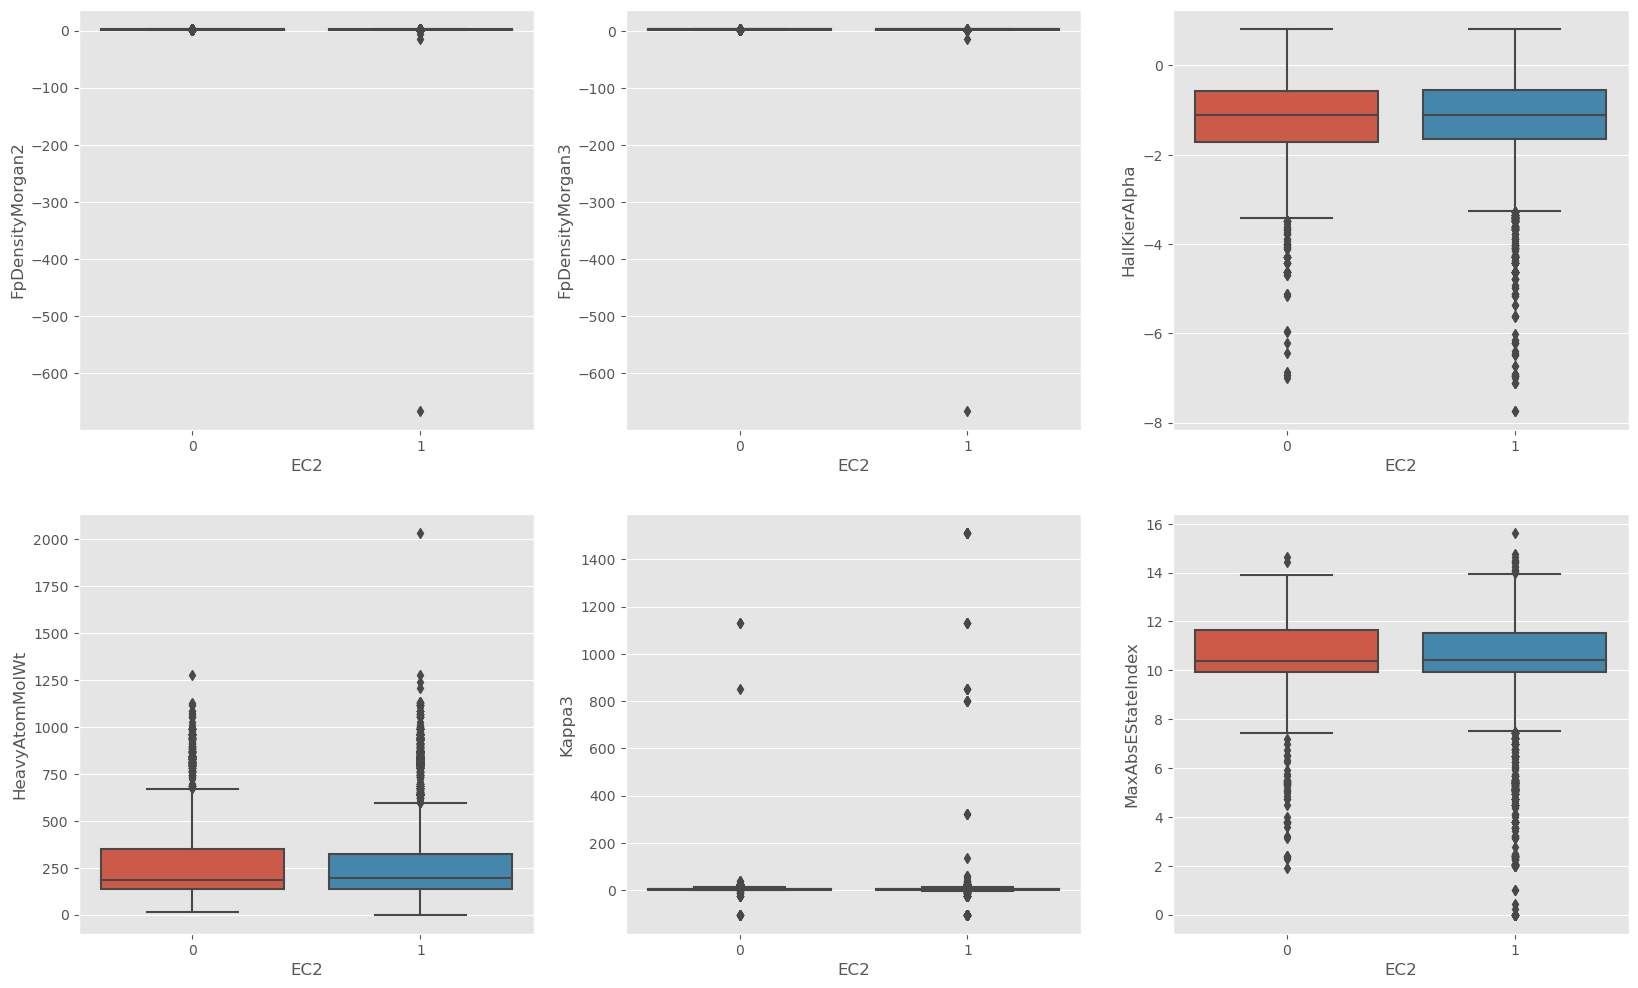

In [15]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC2', y = 'FpDensityMorgan2')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC2', y = 'FpDensityMorgan3')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC2', y = 'HallKierAlpha')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC2', y = 'HeavyAtomMolWt')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC2', y = 'Kappa3')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC2', y = 'MaxAbsEStateIndex');

In the `FpDensityMorgan2` and `FpDensityMorgan3` boxplos, there are data points that are very different.

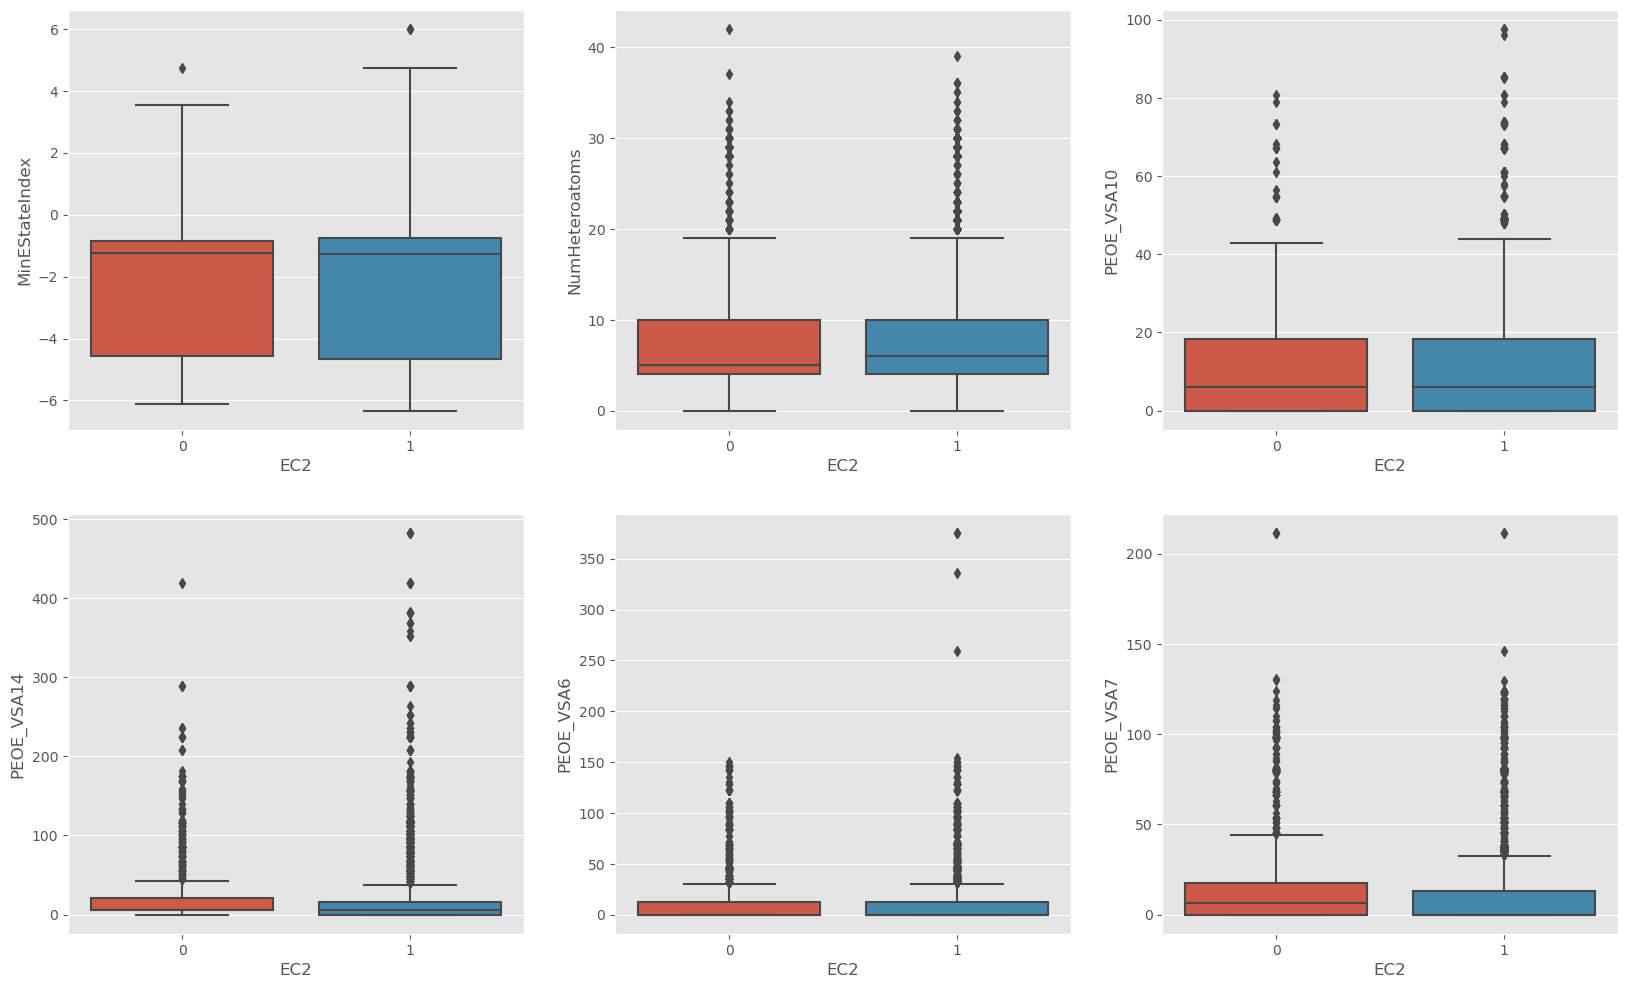

In [16]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC2', y = 'MinEStateIndex')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC2', y = 'NumHeteroatoms')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC2', y = 'PEOE_VSA10')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC2', y = 'PEOE_VSA14')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC2', y = 'PEOE_VSA6')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC2', y = 'PEOE_VSA7');

From the above boxplots, there is not an obvious pattern to exploit. 

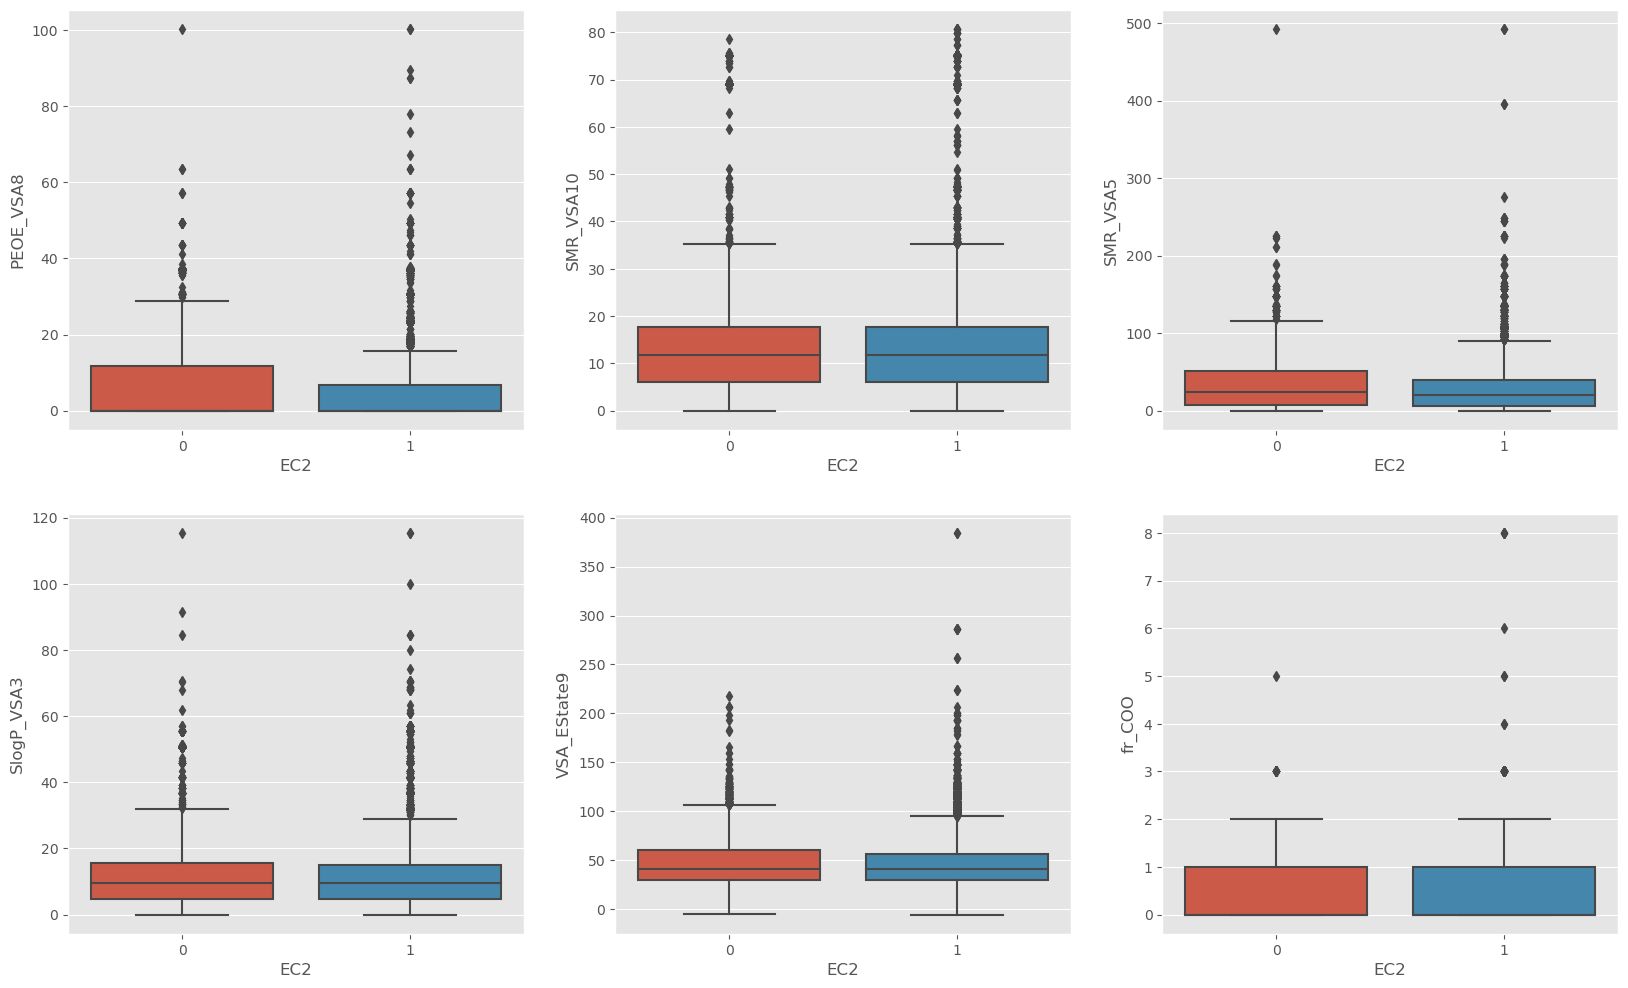

In [17]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.boxplot(ax = axes[0, 0], data = train, x = 'EC2', y = 'PEOE_VSA8')
sns.boxplot(ax = axes[0, 1], data = train, x = 'EC2', y = 'SMR_VSA10')
sns.boxplot(ax = axes[0, 2], data = train, x = 'EC2', y = 'SMR_VSA5')
sns.boxplot(ax = axes[1, 0], data = train, x = 'EC2', y = 'SlogP_VSA3')
sns.boxplot(ax = axes[1, 1], data = train, x = 'EC2', y = 'VSA_EState9')
sns.boxplot(ax = axes[1, 2], data = train, x = 'EC2', y = 'fr_COO');

From the above boxplots, there is not an obvious pattern to exploit.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start building a couple of baseline models using the `FLAML` framework (without any pre-processing of the input features). Also, I used the hill-climbing method for ensemble purposes presented in this [notebook](https://www.kaggle.com/code/samuelcortinhas/ps-s3e3-hill-climbing-like-a-gm).

In [18]:
def hill_climbing(x, y, x_test):
    
    # Evaluate oof preds
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sort scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(0.01, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            # print(f'Iteration: {j}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}')
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]

[](http://)

In [19]:
X = train.drop(columns = ['id', 'HeavyAtomMolWt','fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], axis = 1)
Y = train['EC1']

test_baseline = test.drop(columns = ['id', 'HeavyAtomMolWt','fr_COO2'], axis = 1)

aml_lgb_cv_scores_EC1, aml_lgb_preds_EC1 = list(), list()
aml_xgb_1_cv_scores_EC1, aml_xgb_1_preds_EC1 = list(), list()
aml_xgb_2_cv_scores_EC1, aml_xgb_2_preds_EC1 = list(), list()
aml_rf_cv_scores_EC1, aml_rf_preds_EC1 = list(), list()
aml_et_cv_scores_EC1, aml_et_preds_EC1 = list(), list()
aml_cat_cv_scores_EC1, aml_cat_preds_EC1 = list(), list()

ens_cv_scores_EC1, ens_preds_EC1 = list(), list()
hill_ens_cv_scores_EC1, hill_ens_preds_EC1 = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ##################
    ## FLAML (LGBM) ##
    ##################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC1.append(aml_lgb_score_fold)
    aml_lgb_preds_EC1.append(aml_lgb_pred_2)
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)
    
    #######################
    ## FLAML (XGBoost 1) ##
    #######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgboost'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_1_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_1_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_1_pred_1)
    aml_xgb_1_cv_scores_EC1.append(aml_xgb_score_fold)
    aml_xgb_1_preds_EC1.append(aml_xgb_1_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 1) oof ROC-AUC is ==>', aml_xgb_score_fold)
    
    #######################
    ## FLAML (XGBoost 2) ##
    #######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgb_limitdepth'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_2_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_2_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_2_pred_1)
    aml_xgb_2_cv_scores_EC1.append(aml_xgb_score_fold)
    aml_xgb_2_preds_EC1.append(aml_xgb_2_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 2) oof ROC-AUC is ==>', aml_xgb_score_fold)
      
    ###########################
    ## FLAML (Random Forest) ##
    ###########################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC1.append(aml_rf_score_fold)
    aml_rf_preds_EC1.append(aml_rf_pred_2)
    
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    ################
    ## FLAML (ET) ##
    ################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['extra_tree'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_et_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_et_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_et_score_fold = roc_auc_score(Y_test, aml_et_pred_1)
    aml_et_cv_scores_EC1.append(aml_rf_score_fold)
    aml_et_preds_EC1.append(aml_rf_pred_2)
    
    print('Fold', i, '==> FLAML (ET) oof ROC-AUC is ==>', aml_et_score_fold)

    
    ######################
    ## FLAML (CatBoost) ##
    ######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC1.append(aml_cat_score_fold)
    aml_cat_preds_EC1.append(aml_cat_pred_2)
    
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_xgb_1_pred_1 + aml_xgb_2_pred_1 + aml_rf_pred_1 + aml_et_pred_1 + aml_cat_pred_1) / 6
    ens_pred_2 = (aml_lgb_pred_2 + aml_xgb_1_pred_2 + aml_xgb_2_pred_2 + aml_rf_pred_2 + aml_et_pred_2 + aml_cat_pred_2) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC1.append(ens_score_fold)
    ens_preds_EC1.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ###################
    ## Hill Climbing ##
    ###################
    
    x = pd.DataFrame({'lgb': aml_lgb_pred_1, 
                      'xgb1': aml_xgb_1_pred_1, 
                      'xgb2': aml_xgb_2_pred_1,
                      'rf': aml_rf_pred_1,
                      'et': aml_et_pred_1,
                      'cat': aml_cat_pred_1})
    y = Y_test.copy()
        
    x_test = pd.DataFrame({'lgb': aml_lgb_pred_2, 
                           'xgb1': aml_xgb_1_pred_2, 
                           'xgb2': aml_xgb_2_pred_2,
                           'rf': aml_rf_pred_2,
                           'et': aml_et_pred_2,
                           'cat': aml_cat_pred_2})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores_EC1.append(hill_ens_score_fold)
    hill_ens_preds_EC1.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.696671667727601
Fold 0 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.7040750118203792
Fold 0 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.6959419767767924
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.7114087640693216
Fold 0 ==> FLAML (ET) oof ROC-AUC is ==> 0.7099422183014268
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.7098808137333363
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.7067133614293346
Fold 0 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7118631578731914
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.6828740612776653
Fold 1 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.6879634765628997
Fold 1 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.6963073339569309
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.6943301068644167
Fold 1 ==> FLAML (ET) oof ROC-AUC is ==> 0.6842720386111925
Fold 1 ==> FLAML (CatBoos

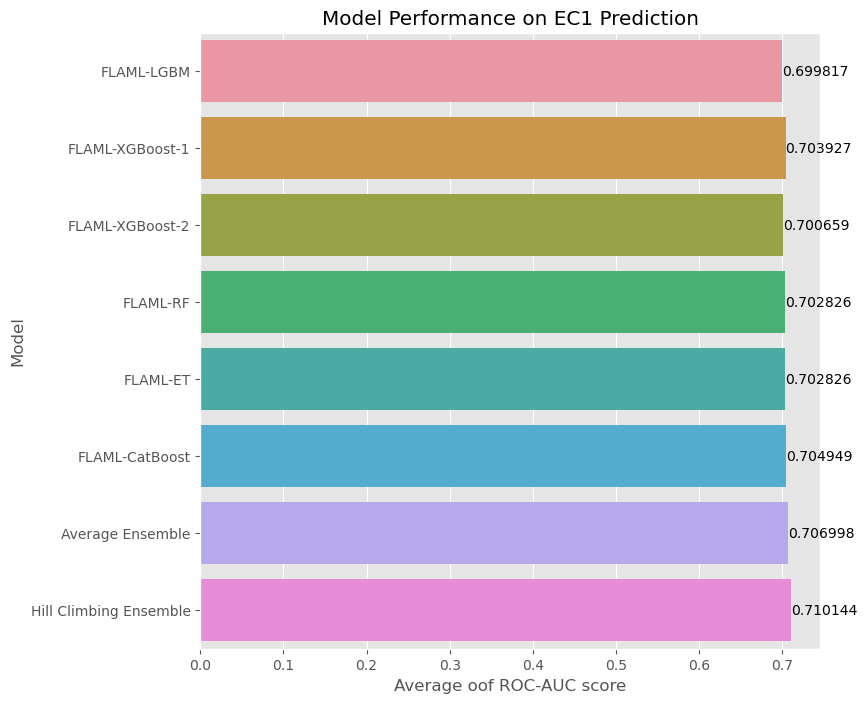

In [20]:
flaml_lgb_EC1 = np.mean(aml_lgb_cv_scores_EC1)
flaml_xgb_1_EC1 = np.mean(aml_xgb_1_cv_scores_EC1)
flaml_xgb_2_EC1 = np.mean(aml_xgb_2_cv_scores_EC1)
flaml_rf_EC1 = np.mean(aml_rf_cv_scores_EC1)
flaml_et_EC1 = np.mean(aml_et_cv_scores_EC1)
flaml_cat_EC1 = np.mean(aml_cat_cv_scores_EC1)
ens_cv_score_EC1 = np.mean(ens_cv_scores_EC1)
hill_ens_cv_score_EC1 = np.mean(hill_ens_cv_scores_EC1)

model_perf = pd.DataFrame({'Model': ['FLAML-LGBM',
                                     'FLAML-XGBoost-1',
                                     'FLAML-XGBoost-2',
                                     'FLAML-RF',
                                     'FLAML-ET',
                                     'FLAML-CatBoost',
                                     'Average Ensemble', 
                                     'Hill Climbing Ensemble'],
                           'cv-score': [flaml_lgb_EC1,
                                        flaml_xgb_1_EC1, 
                                        flaml_xgb_2_EC1,
                                        flaml_rf_EC1,
                                        flaml_et_EC1,
                                        flaml_cat_EC1,
                                        ens_cv_score_EC1,
                                        hill_ens_cv_score_EC1]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.set_xlabel('Average oof ROC-AUC score')
ax.set_title('Model Performance on EC1 Prediction')
ax.bar_label(ax.containers[0]);

In [21]:
X = train.drop(columns = ['id', 'HeavyAtomMolWt','fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], axis = 1)
Y = train['EC2']

test_baseline = test.drop(columns = ['id', 'HeavyAtomMolWt','fr_COO2'], axis = 1)

aml_lgb_cv_scores_EC2, aml_lgb_preds_EC2 = list(), list()
aml_xgb_1_cv_scores_EC2, aml_xgb_1_preds_EC2 = list(), list()
aml_xgb_2_cv_scores_EC2, aml_xgb_2_preds_EC2 = list(), list()
aml_rf_cv_scores_EC2, aml_rf_preds_EC2 = list(), list()
aml_et_cv_scores_EC2, aml_et_preds_EC2 = list(), list()
aml_cat_cv_scores_EC2, aml_cat_preds_EC2 = list(), list()

ens_cv_scores_EC2, ens_preds_EC2 = list(), list()
hill_ens_cv_scores_EC2, hill_ens_preds_EC2 = list(), list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ##################
    ## FLAML (LGBM) ##
    ##################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['lgbm'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_lgb_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_lgb_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_lgb_score_fold = roc_auc_score(Y_test, aml_lgb_pred_1)
    aml_lgb_cv_scores_EC2.append(aml_lgb_score_fold)
    aml_lgb_preds_EC2.append(aml_lgb_pred_2)
    
    print('Fold', i, '==> FLAML (LGBM) oof ROC-AUC is ==>', aml_lgb_score_fold)
    
    #######################
    ## FLAML (XGBoost 1) ##
    #######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgboost'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_1_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_1_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_1_pred_1)
    aml_xgb_1_cv_scores_EC2.append(aml_xgb_score_fold)
    aml_xgb_1_preds_EC2.append(aml_xgb_1_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 1) oof ROC-AUC is ==>', aml_xgb_score_fold)
    
    #######################
    ## FLAML (XGBoost 2) ##
    #######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['xgb_limitdepth'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_xgb_2_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_xgb_2_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_xgb_score_fold = roc_auc_score(Y_test, aml_xgb_2_pred_1)
    aml_xgb_2_cv_scores_EC2.append(aml_xgb_score_fold)
    aml_xgb_2_preds_EC2.append(aml_xgb_2_pred_2)
    
    print('Fold', i, '==> FLAML (XGBoost 2) oof ROC-AUC is ==>', aml_xgb_score_fold)
      
    ###########################
    ## FLAML (Random Forest) ##
    ###########################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['rf'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_rf_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_rf_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_rf_score_fold = roc_auc_score(Y_test, aml_rf_pred_1)
    aml_rf_cv_scores_EC2.append(aml_rf_score_fold)
    aml_rf_preds_EC2.append(aml_rf_pred_2)
    
    print('Fold', i, '==> FLAML (RF) oof ROC-AUC is ==>', aml_rf_score_fold)

    ################
    ## FLAML (ET) ##
    ################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['extra_tree'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_et_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_et_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_et_score_fold = roc_auc_score(Y_test, aml_et_pred_1)
    aml_et_cv_scores_EC2.append(aml_rf_score_fold)
    aml_et_preds_EC2.append(aml_rf_pred_2)
    
    print('Fold', i, '==> FLAML (ET) oof ROC-AUC is ==>', aml_et_score_fold)

    
    ######################
    ## FLAML (CatBoost) ##
    ######################
    
    automl = AutoML()
    
    automl_settings = {'time_budget': 120,  
                       'metric': 'roc_auc',
                       'task': 'classification',
                       'estimator_list': ['catboost'],
                       'log_file_name': '',
                       'seed': 10
                      }

    automl.fit(X_train = X_train, y_train = Y_train, **automl_settings, verbose = False)
    
    aml_cat_pred_1 = automl.predict_proba(X_test)[:, 1]
    aml_cat_pred_2 = automl.predict_proba(test_baseline)[:, 1]

    aml_cat_score_fold = roc_auc_score(Y_test, aml_cat_pred_1)
    aml_cat_cv_scores_EC2.append(aml_cat_score_fold)
    aml_cat_preds_EC2.append(aml_cat_pred_2)
    
    print('Fold', i, '==> FLAML (CatBoost) oof ROC-AUC is ==>', aml_cat_score_fold)
    
    ######################
    ## Average Ensemble ##
    ######################
    
    ens_pred_1 = (aml_lgb_pred_1 + aml_xgb_1_pred_1 + aml_xgb_2_pred_1 + aml_rf_pred_1 + aml_et_pred_1 + aml_cat_pred_1) / 6
    ens_pred_2 = (aml_lgb_pred_2 + aml_xgb_1_pred_2 + aml_xgb_2_pred_2 + aml_rf_pred_2 + aml_et_pred_2 + aml_cat_pred_2) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores_EC2.append(ens_score_fold)
    ens_preds_EC2.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ###################
    ## Hill Climbing ##
    ###################
    
    x = pd.DataFrame({'lgb': aml_lgb_pred_1, 
                      'xgb1': aml_xgb_1_pred_1, 
                      'xgb2': aml_xgb_2_pred_1,
                      'rf': aml_rf_pred_1,
                      'et': aml_et_pred_1,
                      'cat': aml_cat_pred_1})
    y = Y_test.copy()
        
    x_test = pd.DataFrame({'lgb': aml_lgb_pred_2, 
                           'xgb1': aml_xgb_1_pred_2, 
                           'xgb2': aml_xgb_2_pred_2,
                           'rf': aml_rf_pred_2,
                           'et': aml_et_pred_2,
                           'cat': aml_cat_pred_2})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores_EC2.append(hill_ens_score_fold)
    hill_ens_preds_EC2.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

---------------------------------------------------------------
Fold 0 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5832574102787554
Fold 0 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.5878764557420465
Fold 0 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.6036278959222247
Fold 0 ==> FLAML (RF) oof ROC-AUC is ==> 0.5872568104394672
Fold 0 ==> FLAML (ET) oof ROC-AUC is ==> 0.5896632411693471
Fold 0 ==> FLAML (CatBoost) oof ROC-AUC is ==> 0.5964340686080333
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.5961299048179544
Fold 0 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.6037920028973369
---------------------------------------------------------------
Fold 1 ==> FLAML (LGBM) oof ROC-AUC is ==> 0.5690833776610795
Fold 1 ==> FLAML (XGBoost 1) oof ROC-AUC is ==> 0.5766096630714036
Fold 1 ==> FLAML (XGBoost 2) oof ROC-AUC is ==> 0.5796145183743224
Fold 1 ==> FLAML (RF) oof ROC-AUC is ==> 0.5735213395656258
Fold 1 ==> FLAML (ET) oof ROC-AUC is ==> 0.5781021877157441
Fold 1 ==> FLAML (CatBoo

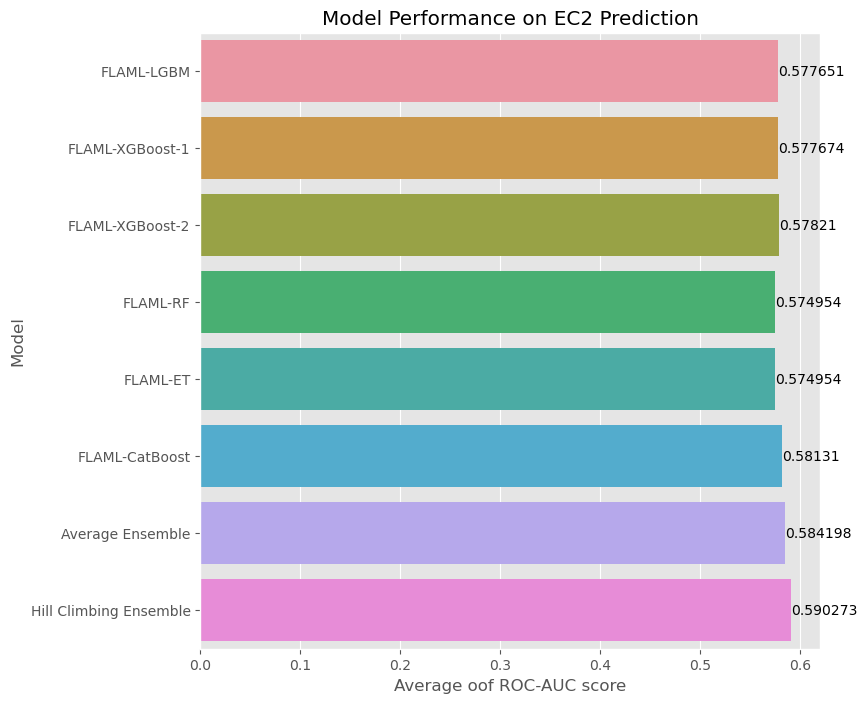

In [22]:
flaml_lgb_EC2 = np.mean(aml_lgb_cv_scores_EC2)
flaml_xgb_1_EC2 = np.mean(aml_xgb_1_cv_scores_EC2)
flaml_xgb_2_EC2 = np.mean(aml_xgb_2_cv_scores_EC2)
flaml_rf_EC2 = np.mean(aml_rf_cv_scores_EC2)
flaml_et_EC2 = np.mean(aml_et_cv_scores_EC2)
flaml_cat_EC2 = np.mean(aml_cat_cv_scores_EC2)
ens_cv_score_EC2 = np.mean(ens_cv_scores_EC2)
hill_ens_cv_score_EC2 = np.mean(hill_ens_cv_scores_EC2)

model_perf = pd.DataFrame({'Model': ['FLAML-LGBM',
                                     'FLAML-XGBoost-1',
                                     'FLAML-XGBoost-2',
                                     'FLAML-RF',
                                     'FLAML-ET',
                                     'FLAML-CatBoost',
                                     'Average Ensemble', 
                                     'Hill Climbing Ensemble'],
                           'cv-score': [flaml_lgb_EC2,
                                        flaml_xgb_1_EC2, 
                                        flaml_xgb_2_EC2,
                                        flaml_rf_EC2,
                                        flaml_et_EC2,
                                        flaml_cat_EC2,
                                        ens_cv_score_EC2,
                                        hill_ens_cv_score_EC2]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.set_xlabel('Average oof ROC-AUC score')
ax.set_title('Model Performance on EC2 Prediction')
ax.bar_label(ax.containers[0]);

In [23]:
ens_preds_test_EC1 = pd.DataFrame(hill_ens_preds_EC1).apply(np.mean, axis = 0)
ens_preds_test_EC2 = pd.DataFrame(hill_ens_preds_EC2).apply(np.mean, axis = 0)

submission['EC1'] = ens_preds_test_EC1
submission['EC2'] = ens_preds_test_EC2
submission.to_csv('FLAML_Hill_Ensemble_submission.csv', index = False)